In [1]:
from pathlib import Path
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import logomaker
import numpy as np
from plot_params import *
plt.style.use('seaborn-white')
basedir = Path('/home/hsher/scratch/ABC_2rep/') # workdir in config file

Matplotlib is building the font cache; this may take a moment.
/scratch/hsher/33698887.tscc-mgr7.local/ipykernel_19010/309882651.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


# Preprocessing Summary
## Adapter cutting

In [2]:
cutadapt = pd.read_csv(basedir/'QC/cutadapt_stat.csv', index_col = 0)

In [3]:
cutadapt.head()

,Total reads processed,Reads with adapters,Reads that were too short,Reads written (passing filters),Total basepairs processed,Quality-trimmed,Total written (filtered),% Reads with adapters,% Reads that were too short,% Reads written (passing filters),% Quality-trimmed,% Total written (filtered)
HEK293_rep1.Tr.metrics,333290558,333290558,189242960,144047598,23996920176,310,7385214702,100.0,56.8,43.2,0.0,30.8
HEK293_rep2.Tr.metrics,238238610,238238610,4975276,233263334,17153179920,268,14259077910,100.0,2.1,97.9,0.0,83.1
K562_rep4.Tr.metrics,316340455,316340455,11194105,305146350,17398725025,0,15382493912,100.0,3.5,96.5,0.0,88.4
K562_rep6.Tr.metrics,236070272,236070272,24585570,211484702,12983864960,0,10539501969,100.0,10.4,89.6,0.0,81.2


Text(0.5, 1.0, 'ABC_2rep')

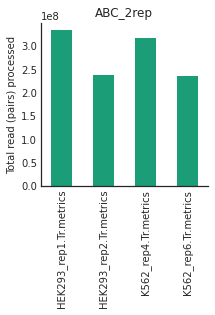

In [4]:
try:
    cutadapt['Total read pairs processed'].sort_index().plot.bar(figsize = (3,3))
    
except:
    cutadapt['Total reads processed'].sort_index().plot.bar(figsize = (3,3))
plt.ylabel('Total read (pairs) processed')
sns.despine()
plt.title(basedir.name)

Text(0.5, 1.0, 'ABC_2rep')

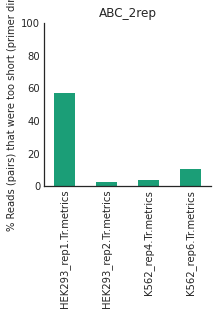

In [5]:
try:
    cutadapt['% Pairs that were too short'].sort_index().plot.bar(figsize = (3,3))
except:
    cutadapt['% Reads that were too short'].sort_index().plot.bar(figsize = (3,3))
plt.ylabel('% Reads (pairs) that were too short (primer dimer)')
plt.ylim(0,100)
sns.despine()
plt.title(basedir.name)

## barcode counts

In [6]:
def get_barcode_counts(basedir):
    demux = pd.read_csv(basedir/'QC/demux_read_count.txt', sep = ' ', header = None, 
            names = ['fname', 'nread'])
    demux[['libname', '.', 'sample_label']] = demux['fname'].str.split('/', expand = True)
    demux = demux.loc[demux['fname']!='total']
    
    demux['RBP']=demux['sample_label'].str.split('_', expand = True)[2].map(
        lambda x: x.replace('.fastq.gz', '') if '5bc' not in x  else 'no barcode')
    count_df = pd.pivot_table(demux, columns = ['libname'], index = ['RBP'], values = ['nread'])
    return count_df

In [7]:
count = get_barcode_counts(basedir)

In [8]:

def annotated_scatterplot(all_read_counts, x, y):
    f, ax = plt.subplots()
    all_read_counts.plot.scatter(x = x, y = y, figsize = (3,3), ax= ax)
    for index, row in all_read_counts[[x,y]].dropna().iterrows():
        ax.text(row[x], row[y], index)
    r,p = pearsonr(all_read_counts[[x,y]].dropna()[x], all_read_counts[[x,y]].dropna()[y])
    sns.despine()
    ax.set_title(f'pearonr={r:.3f}')

In [9]:
count.sort_values(by = count.columns[0])

nread                                
libname HEK293_rep1 HEK293_rep2 K562_rep4 K562_rep6
RBP                                                
PUM2        1474137     2655661   3542878   2446430
EIF3G       3633297     6317804   7212040   5095907
ZC3H11A     4527831     7579618  12467675   8848408
LIN28B      5964362     9262252  15056260  10269990
SF3B4      10826433    21206715  48410568  41963763
DDX3       13044240    20783661  25987615  16319245
FAM120A    20012437    32885790  55847343  39372626
PRPF8      20053333    34334353  43597439  23873473
IGF2BP2    21993139    48007677  29801043  19306020
RBFOX2     22272770    38294968  49933987  32152995

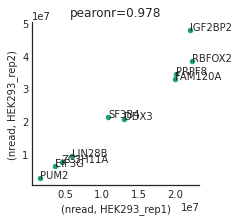

In [10]:
annotated_scatterplot(count, x = count.columns[0], y = count.columns[1])

## FastQC

In [11]:
fastqc = pd.read_csv(basedir/'QC/fastQC_basic_summary.csv', index_col = 0)
fastqc_ps = pd.read_csv(basedir/'QC/fastQC_passfail.csv', index_col = 0)


In [12]:
fastqc_ps.apply(pd.Series.value_counts, axis = 0).fillna(0)

,Basic Statistics,Per base sequence quality,Per tile sequence quality,Per sequence quality scores,Per base sequence content,Per sequence GC content,Per base N content,Sequence Length Distribution,Sequence Duplication Levels,Overrepresented sequences,Adapter Content,Adapter Content.1
fail,0.0,0.0,0.0,0.0,10,27,0.0,0.0,40.0,9.0,0.0,0.0
pass,40.0,40.0,38.0,40.0,5,3,40.0,0.0,0.0,0.0,40.0,40.0
warn,0.0,0.0,2.0,0.0,25,10,0.0,40.0,0.0,31.0,0.0,0.0


In [13]:
fastqc_ps['Adapter Content'].value_counts()

pass    40
Name: Adapter Content, dtype: int64

## Mapping Statistics

In [14]:
genome_stat = pd.read_csv(basedir/'QC/mapping_stats.csv', index_col = 0)

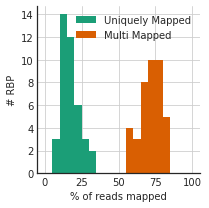

In [15]:
f, ax = plt.subplots(1,1, figsize = (3,3))

genome_stat['Uniquely mapped reads %'].hist(ax = ax, range = (0,100), bins = 20, label = 'Uniquely Mapped')

genome_stat['% of reads mapped to multiple loci'].hist(ax = ax, range = (0,100), bins = 20, label = 'Multi Mapped')
ax.set_xlabel('% of reads mapped')
ax.set_ylabel('# RBP')
sns.despine()
plt.tight_layout()
plt.legend()


In [16]:
cols = ['% of reads mapped to too many loci',
       '% of reads unmapped: too many mismatches',
        '% of reads unmapped: too short',
        '% of reads unmapped: other',
       ]
genome_stat[cols].mean(axis = 0)

% of reads mapped to too many loci           0.00225
% of reads unmapped: too many mismatches     0.00000
% of reads unmapped: too short              10.33650
% of reads unmapped: other                   0.74175
dtype: float64

In [17]:
genome_stat['Average input read length'].mean()

43.125

/home/hsher/miniconda3/envs/Metadensity/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


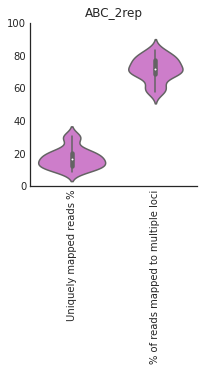

In [18]:

f, ax = plt.subplots(figsize = (3,3))
sns.violinplot(data = genome_stat[['Uniquely mapped reads %','% of reads mapped to multiple loci']],
              color = 'orchid', ax = ax, rot = 90)
plt.xticks(rotation=90)
plt.ylim(0,100)
plt.title(basedir.name)
sns.despine()

## PCR duplication level

In [19]:
dup_df = pd.read_csv(basedir/'QC/dup_level.csv', index_col = 0)

In [20]:
dup_df['libname']=dup_df['dup_bam'].str.split('/', expand = True)[0]

<AxesSubplot: xlabel='libname', ylabel='percent unique fragment'>

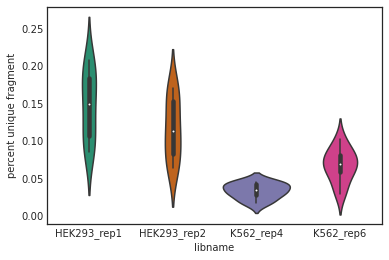

In [21]:
sns.violinplot(data = dup_df, y= 'percent unique fragment', x='libname')

# Show uneven-ness of counts and sequencing depth

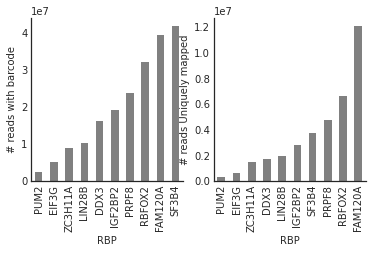

In [22]:
f, ax = plt.subplots(1,2, figsize = (6,3))
count[('nread','K562_rep6')].sort_values().plot.bar(
    ax = ax[0], color = 'grey')
ax[0].set_ylabel('# reads with barcode')

genome_stat['RBP'] = genome_stat['STAR Log filename'].apply(
    lambda name: name.split('/')[-1].split('.')[0])
genome_stat.loc[genome_stat['STAR Log filename'].str.contains('K562_rep6')
               ].set_index('RBP')['Uniquely mapped reads number'].sort_values().plot.bar(
    ax = ax[1], color = 'grey')
ax[1].set_ylabel('# reads Uniquely mapped')

region_type = pd.read_csv(basedir/'QC'/'read_count' /'K562_rep6.region.csv', index_col = 0).T
gene_type = pd.read_csv(basedir/'QC'/'read_count' /'K562_rep6.genetype.csv', index_col = 0).T
sns.despine()
plt.savefig(figdir / 'uneven_library.pdf')

In [23]:
','.join(genome_stat['RBP'].unique())

'IGF2BP2,RBFOX2,PUM2,FAM120A,DDX3,ZC3H11A,EIF3G,PRPF8,LIN28B,SF3B4'

In [24]:
list((basedir/'QC'/'read_count').glob('K562_rep6*region.csv'))

[PosixPath('/home/hsher/scratch/ABC_2rep/QC/read_count/K562_rep6.region.csv')]

In [25]:
genome_stat['RBP'] = genome_stat['STAR Log filename'].apply(lambda name: name.split('/')[-1].split('.')[0])
genome_stat.loc[genome_stat['STAR Log filename'].str.contains('K562_rep6')].set_index('RBP')['Uniquely mapped reads number']

RBP
IGF2BP2     2771622.0
RBFOX2      6594030.0
PUM2         326942.0
FAM120A    12103073.0
DDX3        1691907.0
ZC3H11A     1504524.0
EIF3G        644490.0
PRPF8       4757556.0
LIN28B      1962512.0
SF3B4       3735827.0
Name: Uniquely mapped reads number, dtype: float64

# Read Level QC

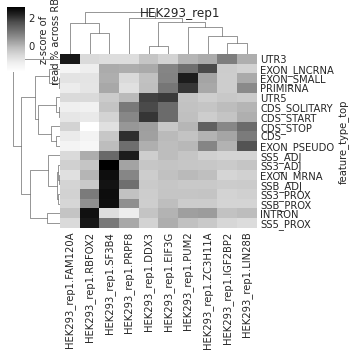

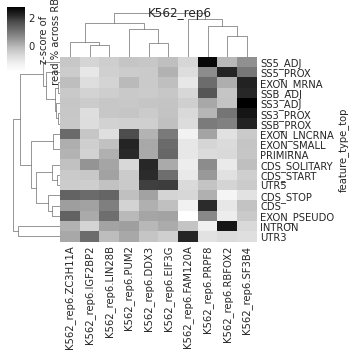

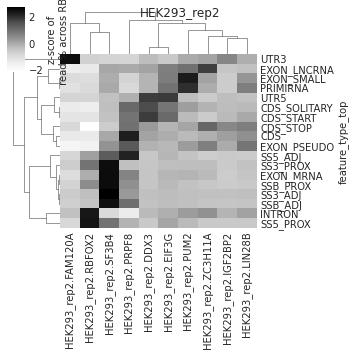

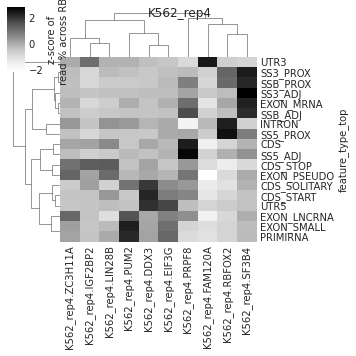

In [26]:
for region_cnt in list((basedir/'QC'/'read_count').glob('*region.csv')):
    region_read_count = pd.read_csv(region_cnt, index_col = 0)
    region_read_perc = region_read_count.div(region_read_count.sum(axis = 0), axis = 1)
    sns.clustermap(region_read_perc,cmap = 'Greys', metric = 'correlation', z_score = 0, figsize = (5,5), cbar_kws = {'label': 'z-score of\n read % across RBP'})
    plt.suptitle(region_cnt.name.split('.')[0])

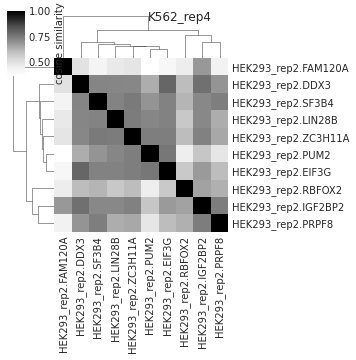

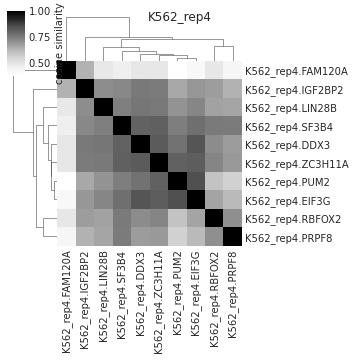

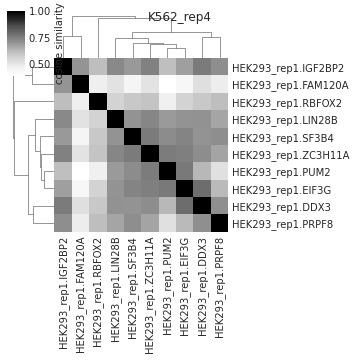

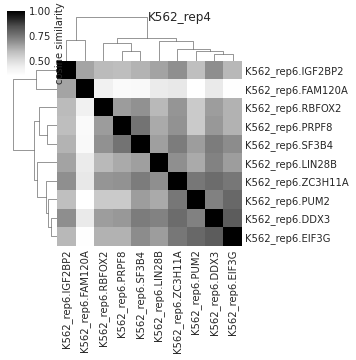

In [27]:
for df in list((basedir/'QC'/'read_count').glob('*cosine_similarity.csv')):
    df = pd.read_csv(df, index_col = 0)
    
    sns.clustermap(df,cmap = 'Greys', metric = 'correlation', figsize = (5,5), cbar_kws = {'label': 'cosine similarity'})
    plt.suptitle(region_cnt.name.split('.')[0])

In [28]:
def is_histone(string):
    ''' based on genename, determine whether it is a histone gene'''
    if 'HIST' in string or string.startswith('H1') | string.startswith('H2') | string.startswith('H3') | string.startswith('H4'):
        return True
    else:
        return False

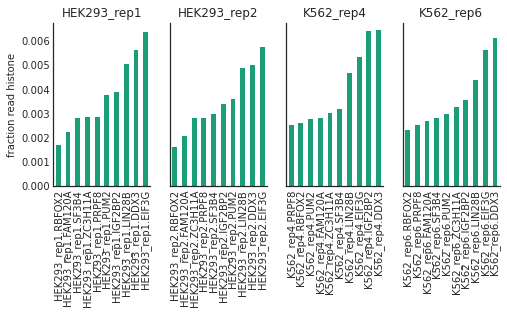

In [29]:
f, axes = plt.subplots(1,4, sharey = True, figsize = (8,3))
for fname, ax in zip(list((basedir/'QC'/'read_count').glob('*genename.csv')), axes):
    df = pd.read_csv(fname, index_col = 0)
    (df.loc[df.index.map(is_histone)].sum()/df.sum(axis = 0)).sort_values().plot.bar(ax = ax)
    ax.set_title(fname.name.split('.')[0])
    ax.set_ylabel('fraction read histone')
sns.despine()

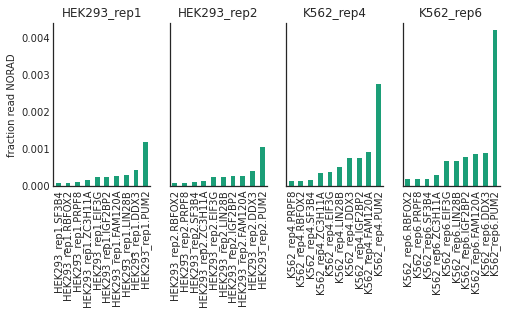

In [30]:
f, axes = plt.subplots(1,4, sharey = True, figsize = (8,3))
for fname, ax in zip(list((basedir/'QC'/'read_count').glob('*genename.csv')), axes):
    df = pd.read_csv(fname, index_col = 0)
    (df.loc['NORAD']/df.sum(axis = 0)).sort_values().plot.bar(ax = ax)
    ax.set_title(fname.name.split('.')[0])
    ax.set_ylabel('fraction read NORAD')
sns.despine()

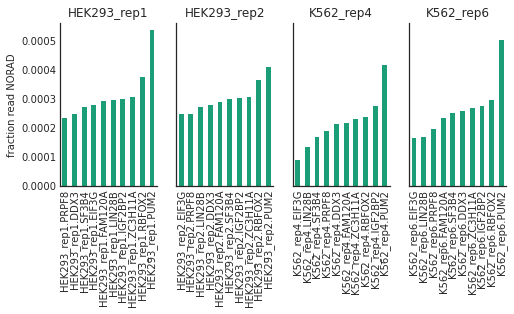

In [31]:
f, axes = plt.subplots(1,4, sharey = True, figsize = (8,3))
for fname, ax in zip(list((basedir/'QC'/'read_count').glob('*genename.csv')), axes):
    df = pd.read_csv(fname, index_col = 0)
    (df.loc['PUM2']/df.sum(axis = 0)).sort_values().plot.bar(ax = ax)
    ax.set_title(fname.name.split('.')[0])
    ax.set_ylabel('fraction read NORAD')
sns.despine()

In [32]:
from pybedtools import BedTool
old_output_dir = Path('/projects/ps-yeolab3/eboyle/encode/pipeline/05_20220720/20220728_encode3/k562/output/reproducible_enriched_windows/')
windows_path = Path('/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz')
def get_eclip_goldstandard(rbps, windows_path, cell_line = 'K562'):
    data = []
    count = []
    window_bed = BedTool(windows_path)
    window_col = pd.read_csv(windows_path, sep = '\t', nrows = 5).columns.tolist()
    for rbp in rbps:
        try:
            reproducible_peak = BedTool(old_output_dir / f'{rbp}_{cell_line}.reproducible_enriched_windows.tsv.gz')
            window = window_bed.intersect(reproducible_peak, s = True, F = 0.5, u = True).to_dataframe(names = window_col)

            window[rbp] = True
            data.append(window.set_index('name')[rbp])
            type_cnt = window['feature_type_top'].value_counts()
            type_cnt.name = rbp
            count.append(type_cnt)
        except Exception as e:
            print(e)
    return pd.concat(data, axis = 1).fillna(False),  pd.concat(count, axis = 1).fillna(0)

In [33]:
# # read counts
# rbps = [c.split('.')[1] for c in df.columns]
# rbps+=['DDX3X', 'CSTF2T', 'TIA1']
# eclip_goldstandard, features = get_eclip_goldstandard(rbps, windows_path)
# for file in list((basedir/'counts'/'genome/megatables').glob('*tsv.gz')):
#     cnt_df = pd.read_csv(file, sep = '\t')
#     cnt_df.index = cnt_df.index+1
#     eclip_odds_df = []
#     merged = cnt_df.merge(eclip_goldstandard, how = 'left', left_index = True, right_index = True).fillna(False)
#     for e in eclip_goldstandard.columns:
#         cnt_by_eclip = merged.groupby(by = e)[cnt_df.columns].sum().T
#         frac_in_eclip = cnt_by_eclip.div(cnt_by_eclip.sum(axis = 0), axis = 1)
#         odds_ratio = (frac_in_eclip[True]/frac_in_eclip[False])
#         odds_ratio.name = e
#         eclip_odds_df.append(odds_ratio)
#     eclip_odds_df = pd.concat(eclip_odds_df, axis = 1)
#     sns.clustermap(eclip_odds_df, cmap = 'Greys', figsize = (4,4))

In [34]:
# cnt_by_eclip.div(cnt_by_eclip.sum(axis = 1), axis = 0)[True]

NameError: name 'cnt_by_eclip' is not defined

In [ ]:
# # read counts

# for file in list((basedir/'counts'/'genome/megatables').glob('*tsv.gz')):
#     cnt_df = pd.read_csv(file, sep = '\t')
#     cnt_df.index = cnt_df.index+1
#     eclip_odds_df = []
#     merged = cnt_df.merge(eclip_goldstandard, how = 'left', left_index = True, right_index = True).fillna(False)
#     for e in eclip_goldstandard.columns:
#         cnt_by_eclip = merged.groupby(by = e)[cnt_df.columns].sum().T
#         perc_read_in_eclip = cnt_by_eclip.div(cnt_by_eclip.sum(axis = 1), axis = 0)[True]
        
#         perc_read_in_eclip.name = e
#         eclip_odds_df.append(perc_read_in_eclip)
#     eclip_odds_df = pd.concat(eclip_odds_df, axis = 1)
#     sns.clustermap(eclip_odds_df, cmap = 'Greys', figsize = (4,4))

# Binding sites
# Dirichlet Multinomial Mixture

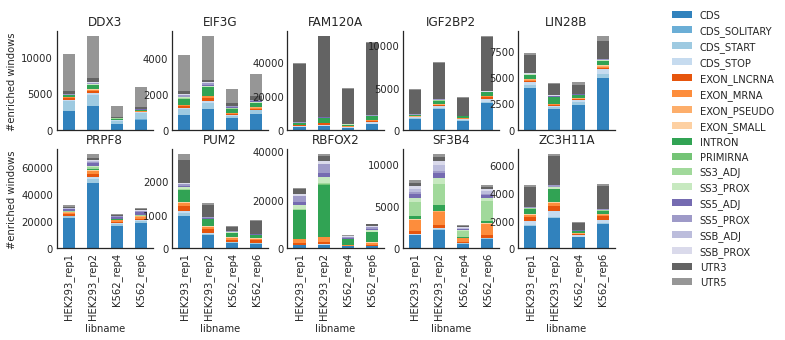

In [35]:
all_counts = []
for fname in list((basedir/'DMM').glob('*enriched_windows.tsv')):
    libname, rbp = fname.name.split('.')[:2]
    df = pd.read_csv(fname, index_col = 0, sep = '\t')
    cnt = df['feature_type_top'].value_counts()
    cnt['libname']=libname
    cnt['RBP'] = rbp
    
    all_counts.append(cnt)
all_counts = pd.concat(all_counts, axis = 1).fillna(0).sort_index().T

sns.set_palette('tab20c')

f, axes = plt.subplots(2,int((len(all_counts['RBP'].unique())+1)/2), figsize = (10,4), sharex = True)
axes = axes.flatten()
i = 0
for rbp, group in all_counts.groupby(by = 'RBP'):
    group.set_index('libname').sort_index().plot.bar(stacked = True, ax = axes[i], legend = False)
    axes[i].set_title(rbp)
    if i%5 == 0:
        axes[i].set_ylabel('#enriched windows')
    i+=1
axes[-1].legend(bbox_to_anchor = (1.5, 2.5))
sns.despine()

## PLOT UNMASKED

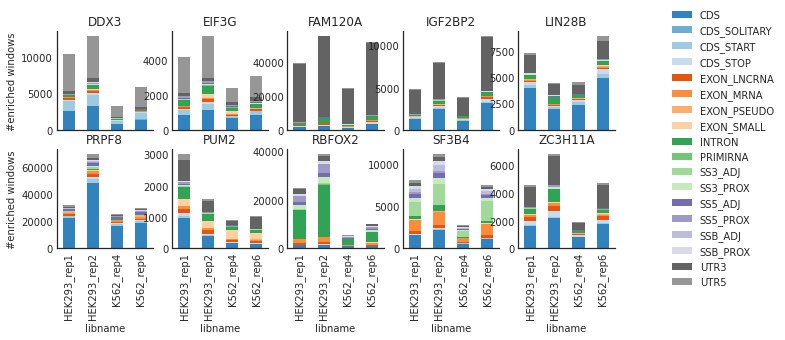

In [37]:
all_counts = []
for fname in list((basedir/'DMM').glob('*megaoutputs_unmasked.tsv')):
    libname = fname.name.split('.')[0]
    df = pd.read_csv(fname, index_col = 0, sep = '\t')
    
    for col in df.columns[df.columns.str.startswith(libname)]:
        cnt = df.loc[df[col],'feature_type_top'].value_counts()
        cnt['libname']=libname
        rbp = col.split('.')[1]
        cnt['RBP'] = rbp
    
        all_counts.append(cnt)
all_counts = pd.concat(all_counts, axis = 1).fillna(0).sort_index().T

sns.set_palette('tab20c')

f, axes = plt.subplots(2,int((len(all_counts['RBP'].unique())+1)/2), figsize = (10,4), sharex = True)
axes = axes.flatten()
i = 0
for rbp, group in all_counts.groupby(by = 'RBP'):
    group.set_index('libname').sort_index().plot.bar(stacked = True, ax = axes[i], legend = False)
    axes[i].set_title(rbp)
    if i%5 == 0:
        axes[i].set_ylabel('#enriched windows')
    i+=1
axes[-1].legend(bbox_to_anchor = (1.5, 2.5))
sns.despine()

# megaoutput_unmask.loc[megaoutput_unmask[f'{out_stem}.PUM2'], 'feature_type_top'
#                      ].value_counts().plot.bar(stacked = True)

## Beta Mixture Model - CC

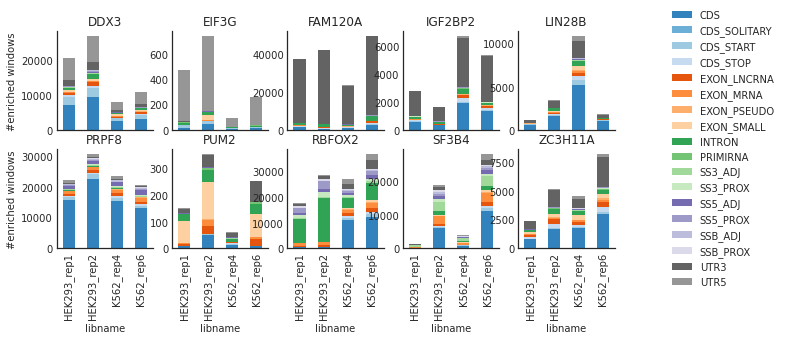

In [38]:
all_counts = []
for fname in list((basedir/'beta-mixture_CC').glob('*enriched_windows.tsv')):
    libname, rbp = fname.name.split('.')[:2]
    df = pd.read_csv(fname, index_col = 0, sep = '\t')
    cnt = df['feature_type_top'].value_counts()
    cnt['libname']=libname
    cnt['RBP'] = rbp
    
    all_counts.append(cnt)
all_counts = pd.concat(all_counts, axis = 1).fillna(0).sort_index().T

sns.set_palette('tab20c')

f, axes = plt.subplots(2,int((len(all_counts['RBP'].unique())+1)/2), figsize = (10,4), sharex = True)
axes = axes.flatten()
i = 0
for rbp, group in all_counts.groupby(by = 'RBP'):
    group.set_index('libname').sort_index().plot.bar(stacked = True, ax = axes[i], legend = False)
    axes[i].set_title(rbp)
    if i%5 == 0:
        axes[i].set_ylabel('#enriched windows')
    i+=1
axes[-1].legend(bbox_to_anchor = (1.5, 2.5))
sns.despine()

In [39]:
beta_mixture_param = []
for fname in list((basedir/'beta-mixture_CC').glob('*alpha.tsv')):
    if 'null' not in str(fname):
        libname, rbp = fname.name.split('.')[:2]
        alpha = pd.read_csv(fname, sep = '\t', index_col = 0)
        alpha_norm = alpha.div(alpha.sum(axis = 0), axis = 1)
        
        n_com = alpha.shape[1]
        
        if n_com > 1:
            selected = alpha_norm.idxmax(axis = 1)[libname+'.'+rbp]
            weights = pd.read_csv(str(fname).replace('.alpha.tsv', '.weights.tsv'), index_col = 0, sep = '\t')
            
            weights.index = [f'X{i}' for i in weights.index]
            pi = weights.loc[selected, 'pi']
            theta = weights.loc[selected, 'theta']
        else:
            selected = None
            pi = None
            theta = None
        beta_mixture_param.append([libname, rbp, pi, n_com, theta, selected])
beta_mixture_param = pd.DataFrame(beta_mixture_param, columns = ['libname', 'RBP', 'pi', 'n_com', 'theta', 'selected'])

In [ ]:
# count_by_lib = count.unstack().reset_index()[['libname', 'RBP', 0]]
# count_by_lib.columns = ['libname', 'RBP', 'nread']
# count_by_lib.merge(beta_mixture_param, left_on= ['libname', 'RBP'], right_on = ['libname', 'RBP']).sort_values(by = ['RBP', 'libname'])

## CLIPper-CC

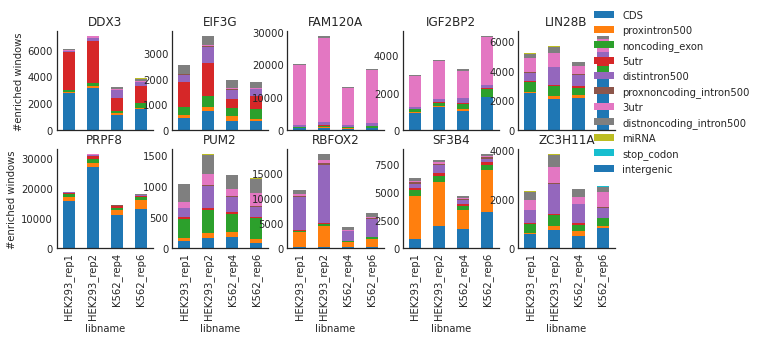

In [40]:
all_clipper_counts = []
l2fc_cutoff = 1
pval_cutoff = 3
for fname in list((basedir/'CLIPper_CC').glob('*normed.compressed.annotate.bed')):
    libname, rbp = fname.name.split('.')[:2]
    normed_df = pd.read_csv(fname, 
                     sep = '\t',
                    names = ['chrom', 'start', 'end', 
                             '-log10pval', 'l2fc', 'strand', 'gene_id',
                             'genename', 'region', 'detail'])
    normed_df = normed_df.loc[(normed_df['-log10pval']>pval_cutoff)&(normed_df['l2fc']>l2fc_cutoff)]
    
    cnt = normed_df['region'].value_counts()
    cnt['libname']=libname
    cnt['RBP'] = rbp
    
    all_clipper_counts.append(cnt)
if all_clipper_counts:
    all_clipper_counts = pd.concat(all_clipper_counts, axis = 1).fillna(0).T
    sns.set_palette('tab10')

    f, axes = plt.subplots(2,int(len(all_clipper_counts['RBP'].unique())/2), figsize = (10,4), sharex = True)
    axes = axes.flatten()
    i = 0
    for rbp, group in all_clipper_counts.groupby(by = 'RBP'):
        group.set_index('libname').sort_index().plot.bar(stacked = True, ax = axes[i], legend = False)
        axes[i].set_title(rbp)
        if i%5 == 0:
            axes[i].set_ylabel('#enriched windows')
        i+=1
    axes[-1].legend(bbox_to_anchor = (2.5, 2.5))
    sns.despine()


# Piranha-CC

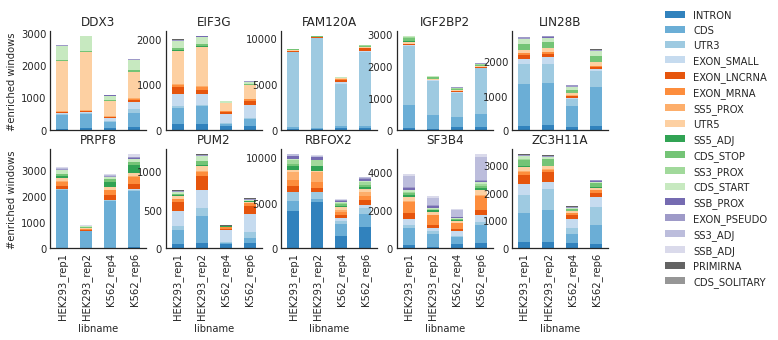

In [42]:
window_df = pd.read_csv('/projects/ps-yeolab4/software/skipper/1.0.0/bin/skipper/annotations/gencode.v38.annotation.k562_totalrna.gt1.tiled_partition.features.tsv.gz',
                       sep = '\t')

indir = basedir / 'comparison' / 'piranha' / 'CC'
piranha_count = []
for f in list(indir.glob(f'*')):
    piranha_df = pd.read_csv(f, names = ['chr', 'start', 'sned', 'name', 'score', 'strand', 'pval', 'cov'], sep = '\t')
    piranha_df['feature_type_top']=piranha_df['name'].map(window_df.set_index('name')['feature_type_top'])
    cnt = piranha_df['feature_type_top'].value_counts()
    cnt['RBP'] = f.name.split('.')[1]
    cnt['libname']=f.name.split('.')[0]
    piranha_count.append(cnt)


if piranha_count:
    piranha_count=pd.concat(piranha_count, axis = 1).fillna(0).T
    sns.set_palette('tab20c')

    f, axes = plt.subplots(2,int(len(piranha_count['RBP'].unique())/2), figsize = (10,4), sharex = True)
    axes = axes.flatten()
    i = 0
    for rbp, group in piranha_count.groupby(by = 'RBP'):
        group.set_index('libname').sort_index().plot.bar(stacked = True, ax = axes[i], legend = False)
        axes[i].set_title(rbp)
        if i%5 == 0:
            axes[i].set_ylabel('#enriched windows')
        i+=1
    axes[-1].legend(bbox_to_anchor = (1.5, 2.5))
    sns.despine()
else:
    print('no Piranha output')

# Skipper-CC

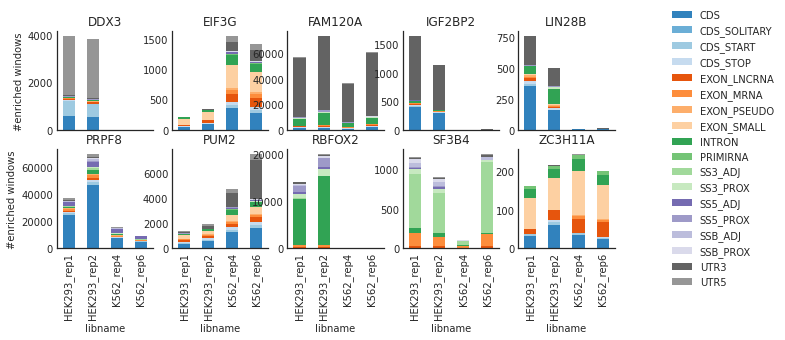

In [43]:

all_counts_skipper = []
d_logs_thres = 0
for fname in list((basedir/'skipper_CC'/'enriched_windows').glob('*enriched_windows.tsv.gz')):
    if 'dlog' not in str(fname):
        libname, rbp = fname.name.split('.')[:2]
        df = pd.read_csv(fname, sep = '\t', index_col = 0)
        df = df.loc[df['d_log_odds']>d_logs_thres]
        
        cnt = df['feature_type_top'].value_counts()
        cnt['libname']=libname
        cnt['RBP'] = rbp

        all_counts_skipper.append(cnt)

if all_counts_skipper:
    all_counts_skipper = pd.concat(all_counts_skipper, axis = 1).fillna(0).sort_index().T
    sns.set_palette('tab20c')

    f, axes = plt.subplots(2,int(len(all_counts_skipper['RBP'].unique())/2), figsize = (10,4), sharex = True)
    axes = axes.flatten()
    i = 0
    for rbp, group in all_counts_skipper.groupby(by = 'RBP'):
        group.set_index('libname').sort_index().plot.bar(stacked = True, ax = axes[i], legend = False)
        axes[i].set_title(rbp)
        if i%5 == 0:
            axes[i].set_ylabel('#enriched windows')
        i+=1
    axes[-1].legend(bbox_to_anchor = (1.5, 2.5))
    sns.despine()
else:
    print('no skipper output')

# Considering external library
## Beta-mixture model

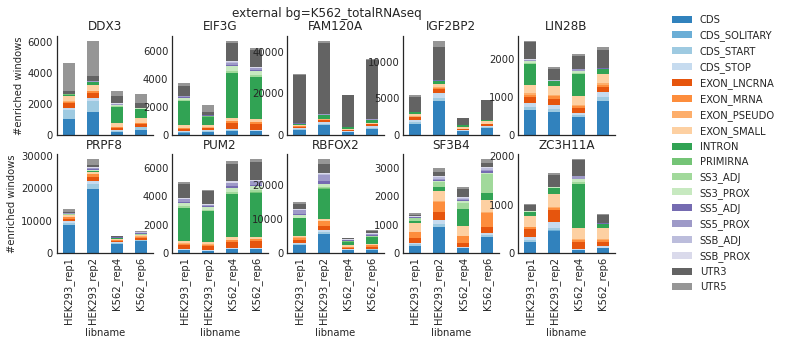

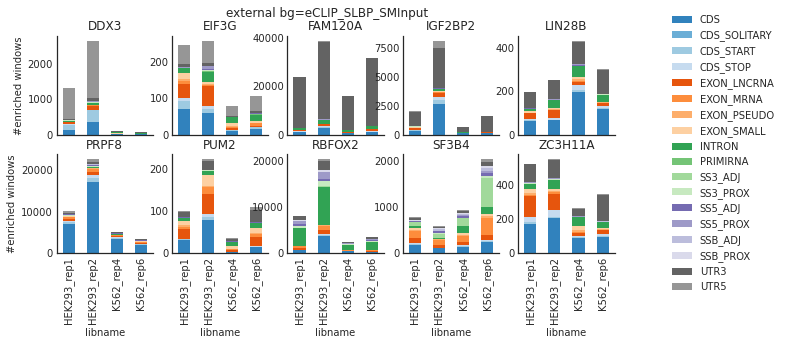

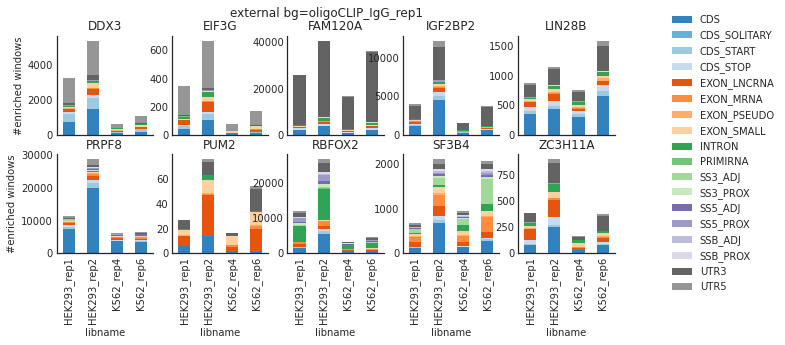

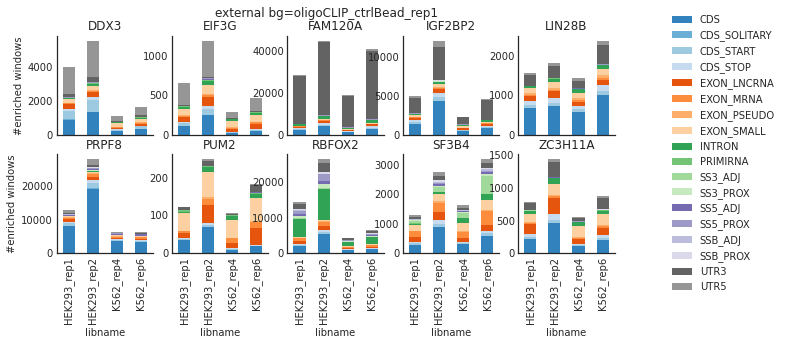

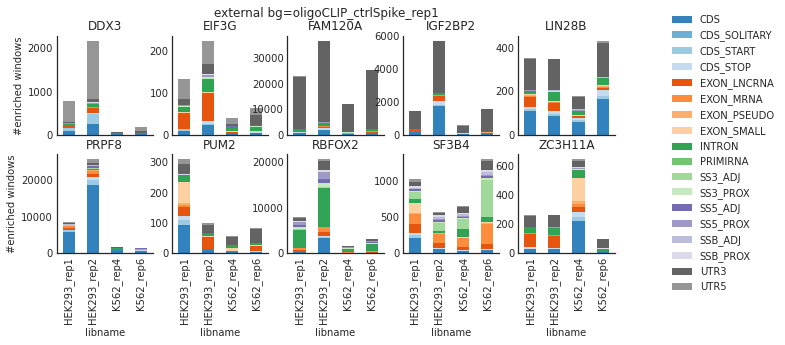

In [44]:
for ext_background in ['K562_totalRNAseq', 'eCLIP_SLBP_SMInput', 
                       'oligoCLIP_IgG_rep1', 'oligoCLIP_ctrlBead_rep1',
                       'oligoCLIP_ctrlSpike_rep1']:
    all_counts = []
    for fname in list((basedir/'beta-mixture_external'/ext_background).glob('*enriched_windows.tsv')):
        libname, rbp = fname.name.split('.')[:2]
        df = pd.read_csv(fname, index_col = 0, sep = '\t')
        cnt = df['feature_type_top'].value_counts()
        cnt['libname']=libname
        cnt['RBP'] = rbp

        all_counts.append(cnt)
    all_counts = pd.concat(all_counts, axis = 1).fillna(0).sort_index().T

    sns.set_palette('tab20c')

    f, axes = plt.subplots(2,int((len(all_counts['RBP'].unique())+1)/2), figsize = (10,4), sharex = True)
    axes = axes.flatten()
    i = 0
    for rbp, group in all_counts.groupby(by = 'RBP'):
        group.set_index('libname').sort_index().plot.bar(stacked = True, ax = axes[i], legend = False)
        axes[i].set_title(rbp)
        if i%5 == 0:
            axes[i].set_ylabel('#enriched windows')
        i+=1
    axes[-1].legend(bbox_to_anchor = (1.5, 2.5))
    sns.despine()
    plt.suptitle(f'external bg={ext_background}')

## Skipper with external background

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


no numeric data to plot DDX3 oligoCLIP_ctrlBead_rep1
no numeric data to plot EIF3G oligoCLIP_ctrlBead_rep1
no numeric data to plot FAM120A oligoCLIP_ctrlBead_rep1
no numeric data to plot IGF2BP2 oligoCLIP_ctrlBead_rep1
no numeric data to plot LIN28B oligoCLIP_ctrlBead_rep1
no numeric data to plot PRPF8 oligoCLIP_ctrlBead_rep1
no numeric data to plot PUM2 oligoCLIP_ctrlBead_rep1
no numeric data to plot RBFOX2 oligoCLIP_ctrlBead_rep1
no numeric data to plot SF3B4 oligoCLIP_ctrlBead_rep1
no numeric data to plot ZC3H11A oligoCLIP_ctrlBead_rep1


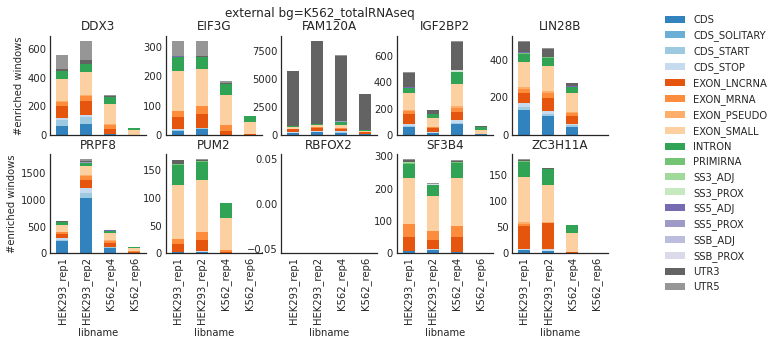

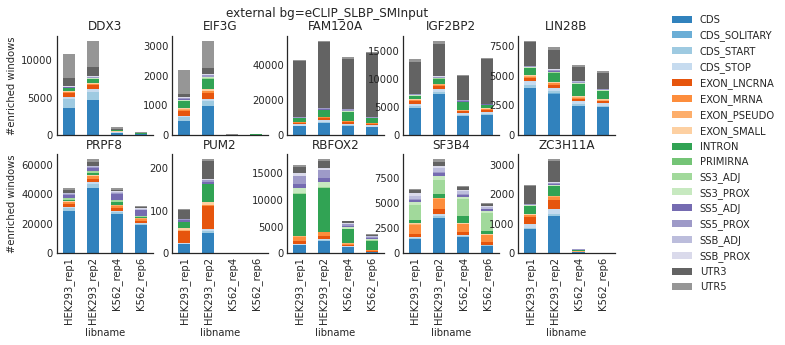

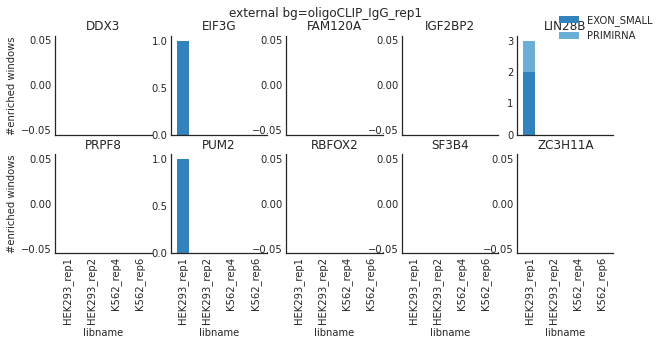

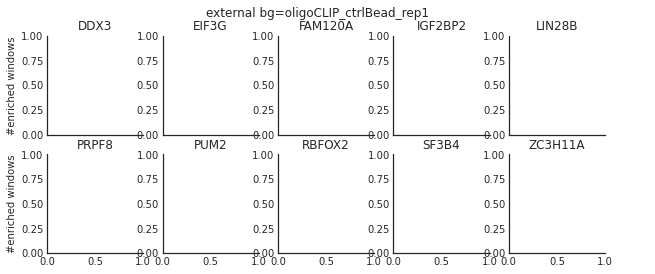

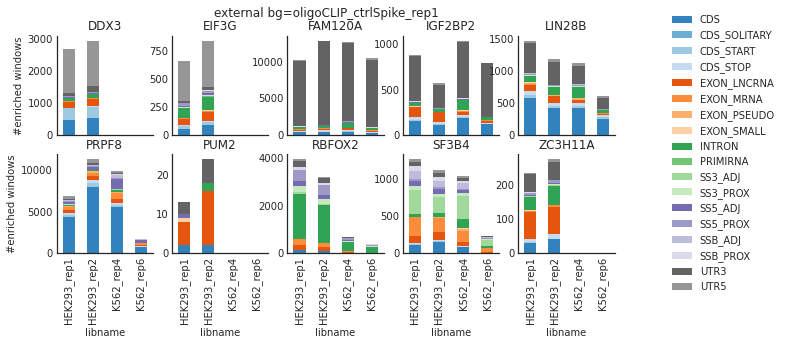

In [45]:
for ext_background in ['K562_totalRNAseq', 'eCLIP_SLBP_SMInput', 
                       'oligoCLIP_IgG_rep1', 'oligoCLIP_ctrlBead_rep1',
                       'oligoCLIP_ctrlSpike_rep1']:
    all_counts_skipper = []
    d_logs_thres = 0
    for fname in list((basedir/'skipper_external'/ext_background/'enriched_windows').glob('*enriched_windows.tsv.gz')):
        if 'dlog' not in str(fname):
            libname, rbp = fname.name.split('.')[:2]
            df = pd.read_csv(fname, sep = '\t', index_col = 0)
            df = df.loc[df['d_log_odds']>d_logs_thres]

            cnt = df['feature_type_top'].value_counts()
            cnt['libname']=libname
            cnt['RBP'] = rbp

            all_counts_skipper.append(cnt)

    if all_counts_skipper:
        all_counts_skipper = pd.concat(all_counts_skipper, axis = 1).fillna(0).sort_index().T
        sns.set_palette('tab20c')

        f, axes = plt.subplots(2,int(len(all_counts_skipper['RBP'].unique())/2), figsize = (10,4), sharex = True)
        axes = axes.flatten()
        i = 0
        for rbp, group in all_counts_skipper.groupby(by = 'RBP'):
            try:
                group.set_index('libname').sort_index().plot.bar(stacked = True, ax = axes[i], legend = False)
            except Exception as e:
                print(e, rbp, ext_background)
            axes[i].set_title(rbp)
            if i%5 == 0:
                axes[i].set_ylabel('#enriched windows')
            i+=1
        axes[-1].legend(bbox_to_anchor = (1.5, 2.5))
        sns.despine()
    else:
        print('no skipper output')
    plt.suptitle(f'external bg={ext_background}')

## CLIPper + external background

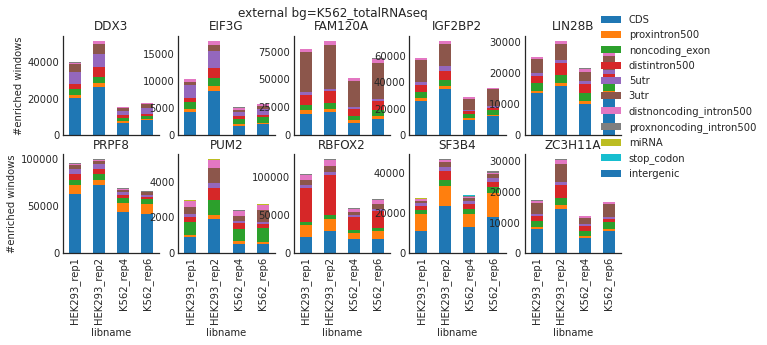

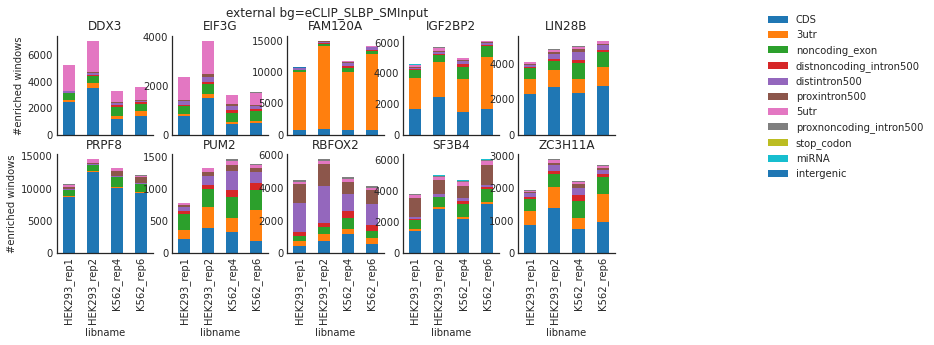

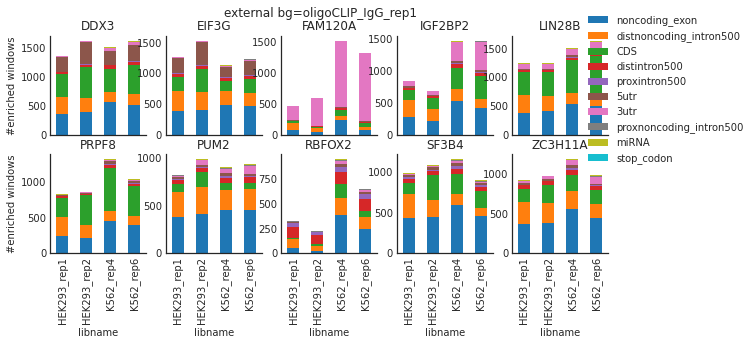

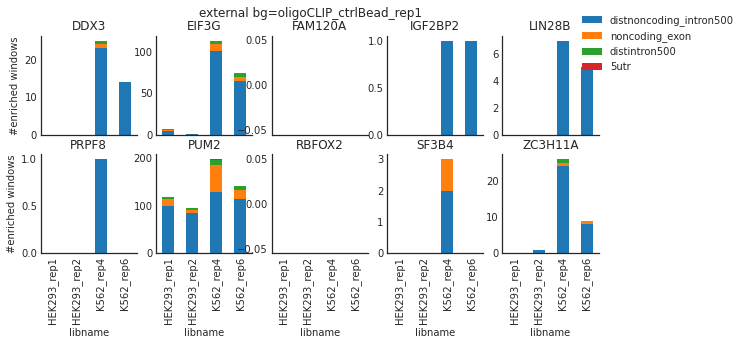

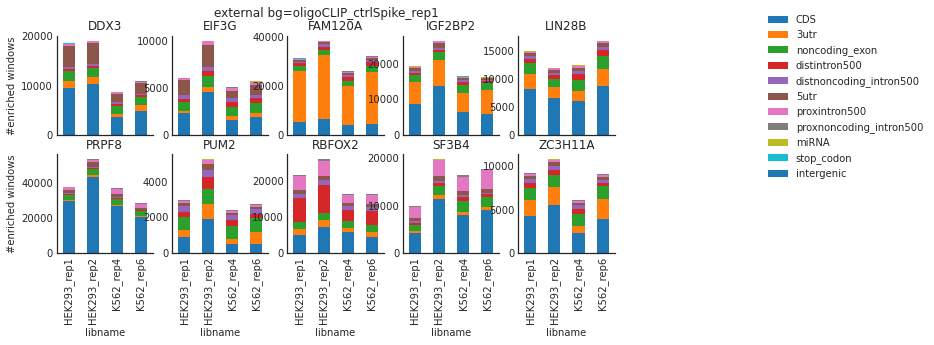

In [46]:
for ext_background in ['K562_totalRNAseq', 'eCLIP_SLBP_SMInput', 
                       'oligoCLIP_IgG_rep1', 'oligoCLIP_ctrlBead_rep1',
                       'oligoCLIP_ctrlSpike_rep1']:
    all_clipper_counts = []
    l2fc_cutoff = 1
    pval_cutoff = 3
    for fname in list((basedir/f'CLIPper-{ext_background}').glob('*normed.compressed.annotate.bed')):
        libname, rbp = fname.name.split('.')[:2]
        normed_df = pd.read_csv(fname, 
                         sep = '\t',
                        names = ['chrom', 'start', 'end', 
                                 '-log10pval', 'l2fc', 'strand', 'gene_id',
                                 'genename', 'region', 'detail'])
        normed_df = normed_df.loc[(normed_df['-log10pval']>pval_cutoff)&(normed_df['l2fc']>l2fc_cutoff)]

        cnt = normed_df['region'].value_counts()
        cnt['libname']=libname
        cnt['RBP'] = rbp

        all_clipper_counts.append(cnt)
    if all_clipper_counts:
        all_clipper_counts = pd.concat(all_clipper_counts, axis = 1).fillna(0).T
        sns.set_palette('tab10')

        f, axes = plt.subplots(2,int(len(all_clipper_counts['RBP'].unique())/2), figsize = (10,4), sharex = True)
        axes = axes.flatten()
        i = 0
        for rbp, group in all_clipper_counts.groupby(by = 'RBP'):
            group.set_index('libname').sort_index().plot.bar(stacked = True, ax = axes[i], legend = False)
            axes[i].set_title(rbp)
            if i%5 == 0:
                axes[i].set_ylabel('#enriched windows')
            i+=1
        axes[-1].legend(bbox_to_anchor = (2.5, 2.5))
        sns.despine()
    plt.suptitle(f'external bg={ext_background}')

In [ ]:
homer_dir = basedir /'internal_output/homer/finemapped_results/COV'
comps = list(homer_dir.glob('*'))
libs = list(set([i.name.split('.')[0] for i in comps]))
rbps = list(set([i.name.split('.')[1] for i in comps]))
if libs and rbps:
    fig, motif_stat = plot_all_homer(libs, rbps, homer_dir)